Mounted at /content/drive


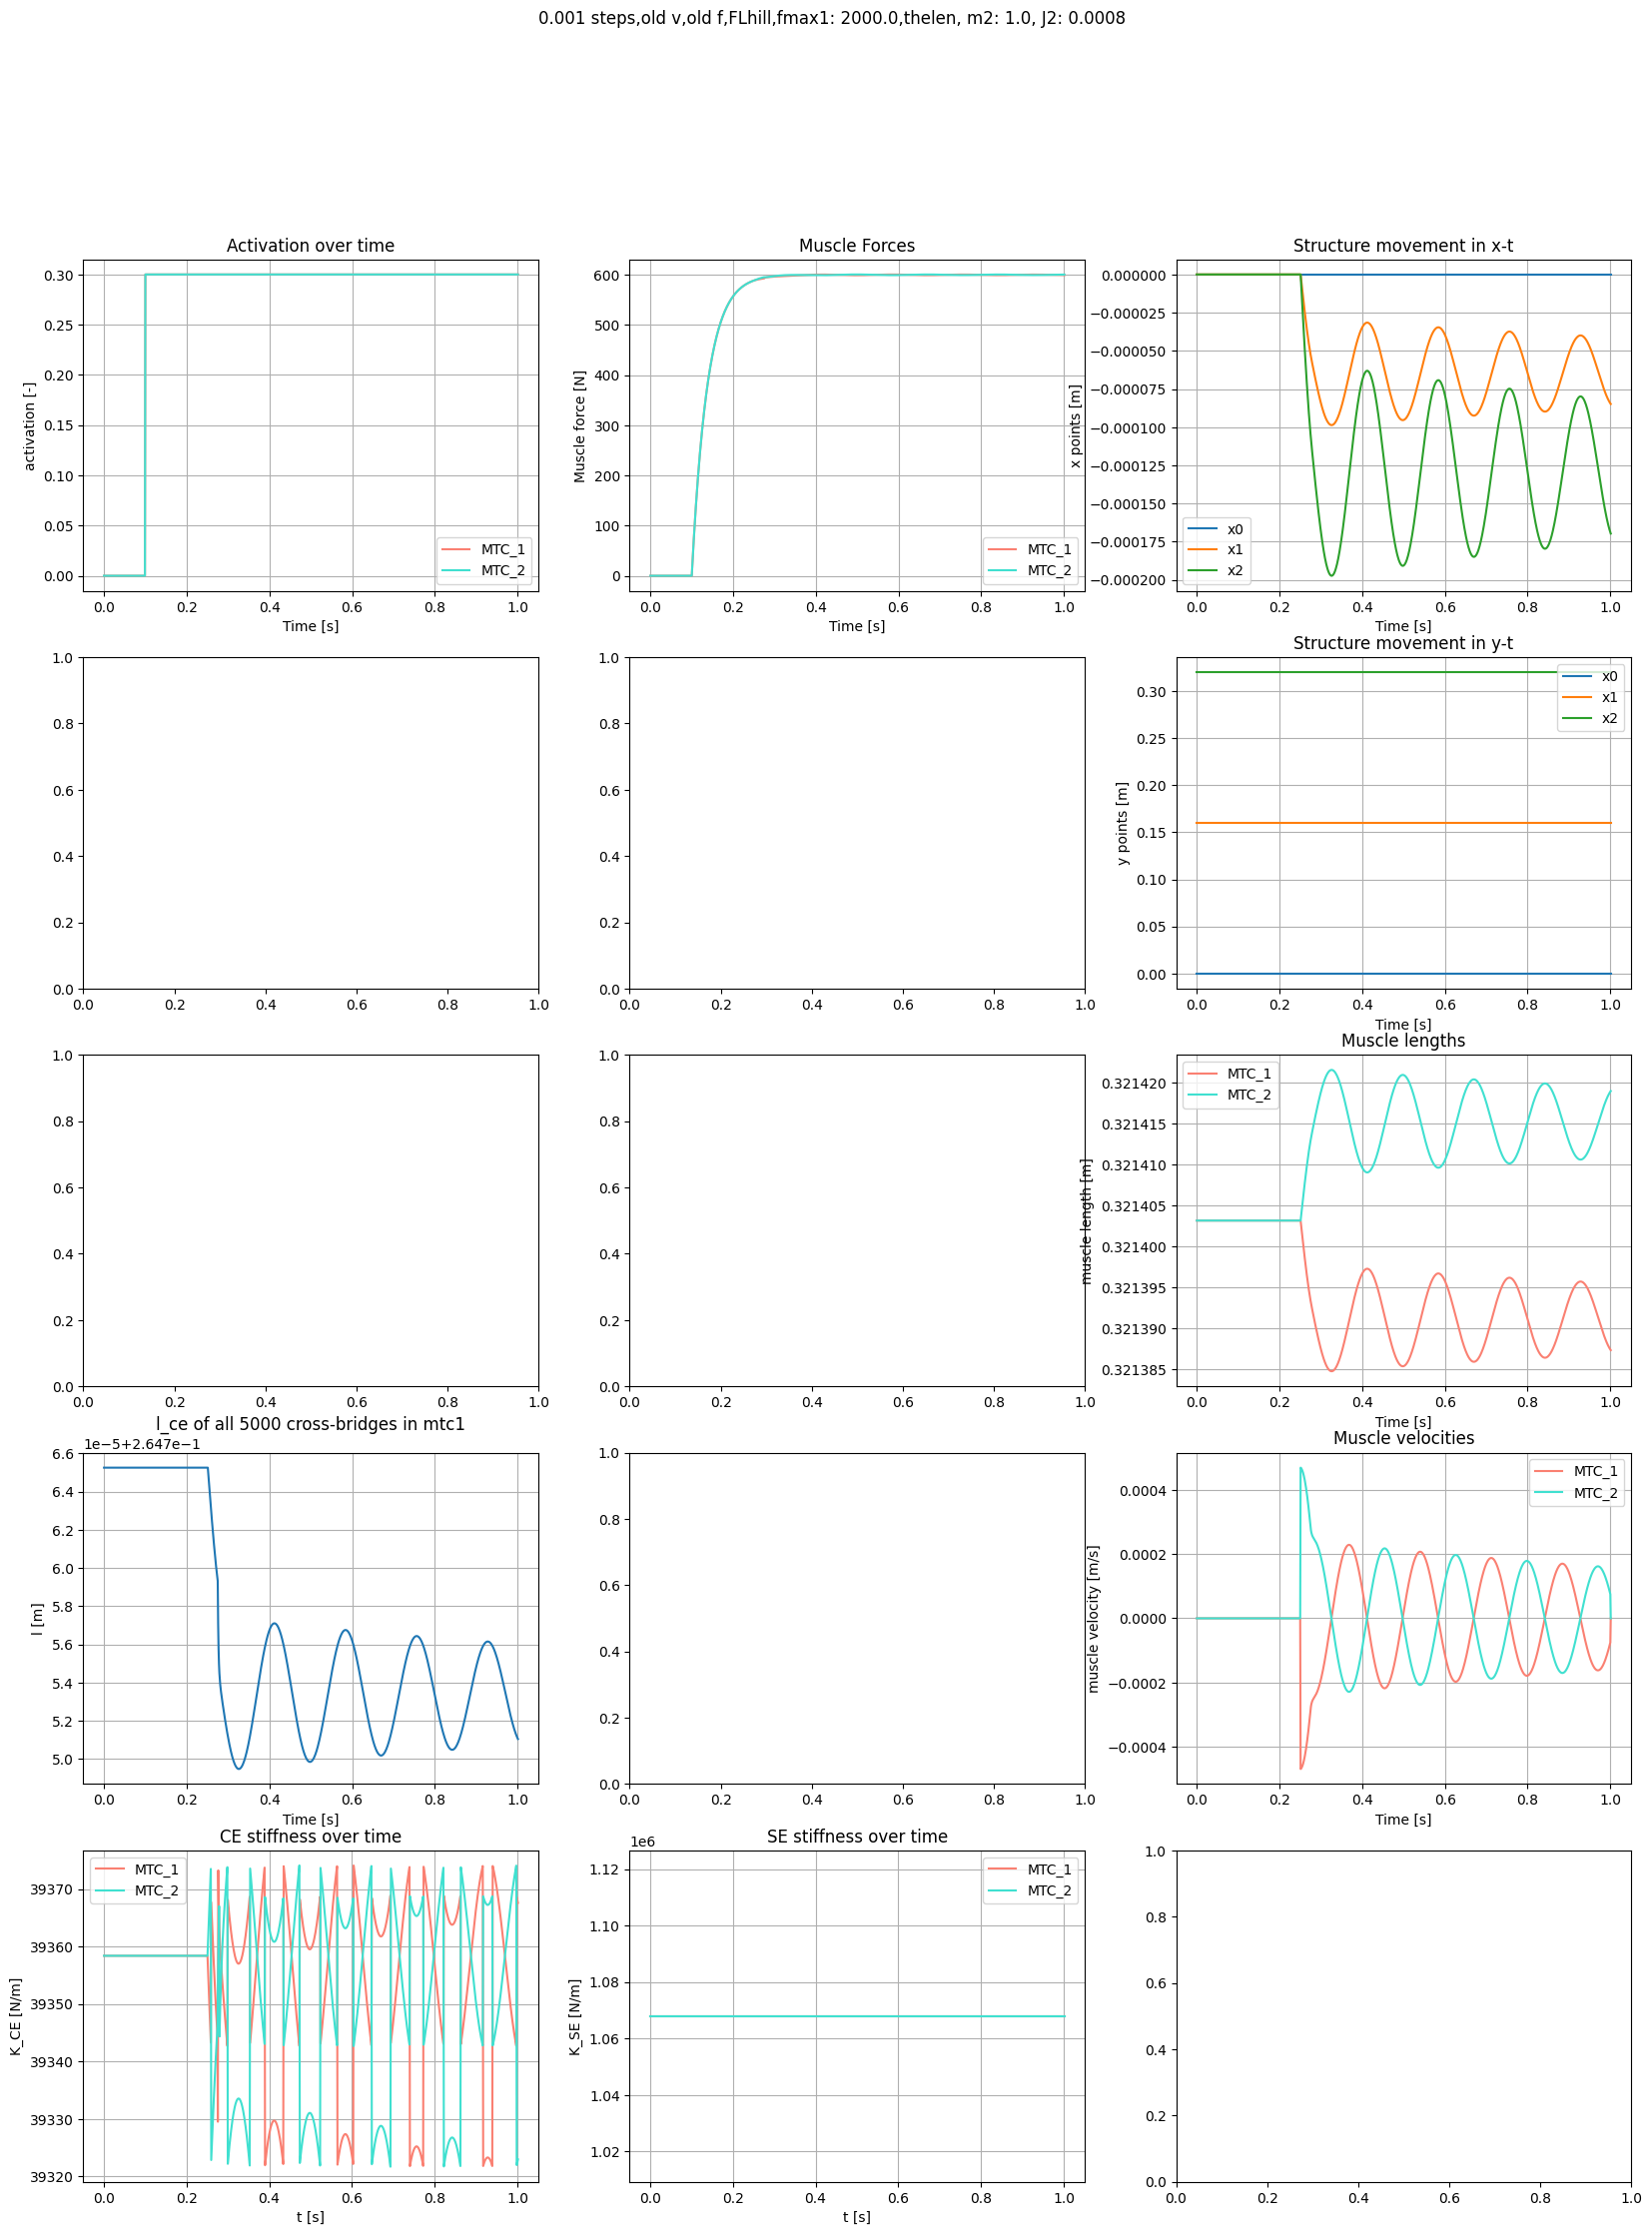

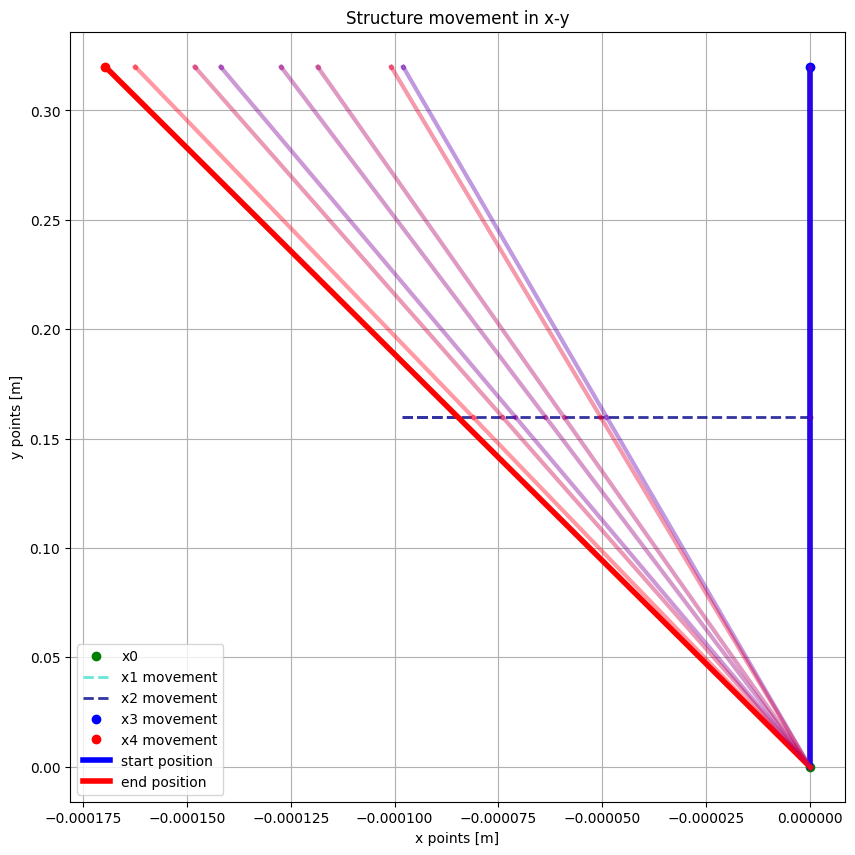

In [ ]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')
root_path = 'drive/My Drive/TU/Master/MEP/Paper/Working_file_copied_from_final_code/Experiment_2a'
import sys, os
#path_dir = os.getcwd()
sys.path.append(root_path+"/Functions")
from general_functions import *
from muscle_functions import *
from integrator_functions import *
from matrices_functions import * #can make specific later if bloated
from constants_functions import *
from plot_functions import *
from save_functions import *

#The stiffness region that the muscles start in must be in the experiment name. Names are:
#mostpos,verypos,newpos,newneg,mostneg for stiffness region 1-5. Region name must be preceded by stiff_start_
experiment_name = 'testWF2b_minimal_cocontraction_stiff_start_newpos_smallincrements_'# or 'stiff_start_neg_ # nothing or smallincrements_
save = True #If true, the experiment data will be saved to a dataset in /Results/data

#protocol indicates the system configuration. 'straight_up_delay' for experiment 2 perturbation test, 'reaching' for experiment 3 robustness test
protocol = 'straight_up_delay'#'stroeve','straight_up','straight_up_delay'


#model type determines whether Huxley or Hill functions are used, v_type determines the used vce equation in the Huxley model (old is used) and FL_.. determines the used FL model (hill is used)
model_type,v_type,FL_type='huxley','v_old','FL_hill' #'huxley','hill'---'v_old','v_new'---'FL_0','FL_hill','FL_huxley'
Fmax_muscles = 2000 #determines the maximum muscle force
hill_type = 'stroeve'#determines the hill model used. 'thijs' for hill_expanded, 'stroeve' for hill_simple
f_type = 'f_damped_fullgrav'#determines how the force vector in matrices_functions.py is calculated. 'f_damped_fullgrav','f_damped__pgrav','f_damped__0grav','f_undamped_fullgrav','f_undamped__pgrav','f_undamped__0grav' ------------apply manually to matrices_functions.py

#some experiment parameters
t0 = 0.0                #time start point (s)
tf = 1.0                #time end point   (s)
t_stimulation = 0.1     #s at this time, the muscle stimulation will start
t_perturbation = 0.25   #s at this time, the system will be perturbated
h_step = 0.001          #stepsize         (s)
muscle_number = 2       #nr of muscles used
tot_bridge_nr = 5000    #number of cross-bridges in the Huxley Model
step_nr = int((tf-t0)/h_step)

stim_multiplier_list = [0.3]#cycle through a list of excitation levels, eg. 1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01

for multiplier_nr in range(len(stim_multiplier_list)):
    stim_multiplier = stim_multiplier_list[multiplier_nr]
    mus_vals = muscle_vals_func()

    for muscle_model_nr in range(1):
        if muscle_model_nr==0:
            model_type='huxley'
        if muscle_model_nr==1:
            model_type='hill'
            hill_type = 'thijs'
        if muscle_model_nr==111:
            model_type='hill'
            hill_type = 'stroeve'




        if model_type == 'huxley':
            specific_save_name = str(model_type)+'_stim_mult'+str(stim_multiplier)
        if model_type == 'hill':
            specific_save_name = str(model_type)+'_'+str(hill_type)+'_stim_mult'+str(stim_multiplier)
        if protocol == 'straight_up_delay':
            starting_a1 = 0.5*sm.pi
        if protocol == 'straight_up':
            starting_a1 = 0.5*sm.pi
        if protocol == 'stroeve':
            starting_a1 = 0.2*sm.pi




        l1, l2,l3,l4,m1, m2, J1, J2,F_mtc1,F_mtc2,F_mtc3,F_mtc4,F_mtc5,F_mtc6,r1,r2,B1,B2,thetar1,thetar2,PE_sh1,PE_sh2,PE_xm1,PE_xm2,T_max1,T_max2 = sm.symbols('l_1,l_2,l_3,l_4, m_1, m_2, J_1, J_2, F_{mtc_1},F_{mtc_2},F_{mtc_3},F_{mtc_4},F_{mtc_5},F_{mtc_6},r_1,r_2,B_1,B_2,theta_{r1},theta_{r2},PE_{sh1},PE_{sh2},PE_{xm1},PE_{xm2},T_{max1},T_{max2}')
        t = sm.symbols('t')
        alpha1 = sm.Function('alpha1')(t)
        alpha2 = sm.Function('alpha2')(t)
        alpha3 = sm.Function('alpha3')(t)
        J3, m3 = sm.symbols('J_3,m_3')
        #The joint locations and body center of masses are defined
        x0=0
        y0=0
        x1=0.5*l1*(sm.cos(alpha1))
        y1=0.5*l1*(sm.sin(alpha1))
        x2=2*x1
        y2=2*y1

        x3=0
        y3=0
        x4=0
        y4=0

        #Here the starting and ending locations of the muscles are defined, which are later included in the state vector
        #this makes the starts and endings of the muscles scale directly with the joint angle
        xm1_start=-sm.sin(starting_a1)*r1 #-sm.sin(alpha1)*r1
        ym1_start=sm.cos(starting_a1)*r1  #sm.cos(alpha1)*r1
        xm1_end  =x2*l3/l1
        ym1_end  =y2*l3/l1
        xm2_start=sm.sin(starting_a1)*r1#sm.sin(alpha1)*r1
        ym2_start=-sm.cos(starting_a1)*r1#-sm.cos(alpha1)*r1
        xm2_end  =x2*l3/l1
        ym2_end  =y2*l3/l1
        l_mtc1=sm.sqrt((xm1_end-xm1_start)**2+(ym1_end-ym1_start)**2)
        l_mtc2=sm.sqrt((xm2_end-xm2_start)**2+(ym2_end-ym2_start)**2)

        x = sm.Matrix([alpha1, x1, y1,alpha2,x2,y2])
        q = sm.Matrix([alpha1,alpha2])
        T_mat = x.diff(t).jacobian(q.diff(t))

        #define constants and specifieds
        p_protocol_straight_up = {
            l1: 0.32,    # m
            l2: 0,  # m
            l3: 0.32,  # m
            l4: 0,    #m
            m1: 1.8,    # kg
            J1: 0.015,    # kg*m^2 https://aip-scitation-org.tudelft.idm.oclc.org/doi/pdf/10.1063/1.3479844#:~:text=We%20can%20see%20that%20the,0.1kgm2%20to%200.5kgm2.
            m2: 1,    # m
            J2: 0.0008, #ball: 2/5*M*r^2. Say r of 0.04m, m of 1: 0.00064. Circle: 0.5*m*r^2   kg*m^2
            r1: 0.03,   #rad
            r2: 0,   #rad
            m3: 0,
            J3: 0,
            B1: 0.3,#Shoulder damping, Nms/rad
            B2: 0,#Elbow damping, Nms/rad
            thetar1: 0.5*np.pi,#Shoulder rest angle, rad
            thetar2: 0,#Elbow rest angle, rad
            PE_sh1: 18,#Shoulder PE shape
            PE_sh2: 0,#Elbow PE shape
            PE_xm1: 0.25*np.pi,#Shoulder PE range, rad
            PE_xm2: 0,#Elbow PE range, rad
            T_max1: 75,#maximum shoulder torque, winters and stark 85
            T_max2: 0,#maximum elbow torque, winters and stark 85
        }

        #initial conditions
        init_protocol_straight_up = {
            alpha1: 0.50*np.pi,
            alpha2: 0*np.pi,
            alpha1.diff(t): 0.01*np.pi,
            alpha2.diff(t): 0,
        }
        init_protocol_straight_up_delay = {
            alpha1: 0.50*np.pi,
            alpha2: 0.0,
            alpha1.diff(t): 0.0,
            alpha2.diff(t): 0.0,
        }
        pert_protocol_straight_up_delay = {
            alpha1: 0.00*np.pi,
            alpha2: 0*np.pi,
            alpha1.diff(t): 0.005*np.pi,
            alpha2.diff(t): 0,
        }
        if protocol == 'straight_up':
            init = init_protocol_straight_up
            p = p_protocol_straight_up
            t_perturbation = False
            pert_vals = False

        if protocol == 'straight_up_delay':
            init = init_protocol_straight_up_delay
            p = p_protocol_straight_up
            pert_vals = np.array(list(pert_protocol_straight_up_delay.values()))
        r = {
            F_mtc1:   1.0,  # N
            F_mtc2:   1.0,  # N
        }

        #invoke system calculation functions
        F_newton, M_newton, q_args, qd_args, p_args, r_args = F_M_vars_calc(l1, l2,l3,l4,m1, m2, J1, J2,F_mtc1,F_mtc2,F_mtc3,F_mtc4,F_mtc5,F_mtc6,r1,r2,t,alpha1,alpha2,x0,x1,x2,x3,x4,y0,y1,y2,y3,y4,p,r,J3,m3,alpha3,B1,B2,thetar1,thetar2,PE_sh1,PE_sh2,PE_xm1,PE_xm2,T_max1,T_max2,f_type);
        M_tmt, Q_tmt, C_M, C_Q, A, b, eval_A, eval_b, eval_C, eval_Cd, eval_Cq, g_conv = matrices_func(M_newton, F_newton, q_args, qd_args, p_args, r_args, T_mat,x,q,t);
        init_vals = np.array(list(init.values()))

        #Make arrays of the values in order for use in the numerical functions
        q_vals = np.array([init_vals[0],init_vals[1]])
        qd_vals = np.array([init_vals[2], init_vals[3]])
        p_vals = np.array([p[p_sym] for p_sym in p_args])
        r_vals = np.array([r[r_sym] for r_sym in r_args])
        eval_xs = sm.lambdify((q_args, p_args), [x0,x1,x2])
        eval_ys = sm.lambdify((q_args, p_args), [y0,y1,y2])
        eval_ls = sm.lambdify((q_args, p_args), [l_mtc1, l_mtc2,0])

        #create function to iterate over with rk4
        eval_rhs2 = lambda t, s, r_vals: eval_rhs(t, s, p_vals, r_vals,eval_A, eval_b)[0]  # don't output the Lagrange multipliers



        #make an input stimulation vector
        step_nr = int((tf-t0)/h_step)
        input_STIM = [[]]*muscle_number
        starting_step = int((t_stimulation/tf)*step_nr)
        input_STIM[0] = np.ones(step_nr+2)*stim_multiplier
        input_STIM[1] = np.ones(step_nr+2)*stim_multiplier
        input_STIM[0][0:starting_step] = 0 #this way, step input should be applied at 0.01 s
        input_STIM[1][0:starting_step] = 0

        #execute calculations
        t_vals, s_vals, coords_vals,mtc_vels,calculated_muscle_forces,states,activation,mus_vals_changed,K_SE_list,K_CE_list,force_vector = rk4_integrator(eval_rhs2, t0, tf, init_vals, t_perturbation,pert_vals,h_step, r_vals, muscle_number, tot_bridge_nr, eval_xs, eval_ys, eval_ls,p_vals,mus_vals,Fmax_muscles,False,True,input_STIM,True,False,model_type,hill_type,v_type,FL_type,True,specific_save_name,experiment_name)

        #some data preparation
        l_mtcs = [[]]*muscle_number
        for muscle in range(muscle_number):
            l_mtcs[muscle] = coords_vals[:,2][:,muscle]
        if model_type =='huxley':
            lCEs = np.zeros((muscle_number,len(states[0][:,-2])))
            lSEs = np.zeros((muscle_number,len(states[0][:,-2])))
            for i in range(muscle_number):
                lCEs[i] = states[i][:,-2]
            for i in range(muscle_number):
                lSEs[i] = coords_vals[:,2,i] - lCEs[i]
        if model_type =='hill':
            if hill_type == 'stroeve':
                lCEs = np.zeros((muscle_number,len(states[0])))
                vCEs = np.zeros((muscle_number,len(states[0])))
                for muscle in range(muscle_number):
                    lCEs[muscle] = l_mtcs[muscle] - 0.02
                    vCEs[muscle] = np.gradient(lCEs[muscle],h_step)
            if hill_type == 'thijs':
                lCEs = np.zeros((muscle_number,len(states[0])))
                vCEs = np.zeros((muscle_number,len(states[0])))
                for muscle in range(muscle_number):
                    lCEs[muscle] = states[muscle][:,0]
                    vCEs[muscle] = force_vector[muscle][:,7]

        #save data to \Results
        if save == True:
            if model_type =='huxley':
                save_huxley(l_mtcs,tot_bridge_nr,states,force_vector,mtc_vels,input_STIM,lCEs,lSEs,K_CE_list,K_SE_list,coords_vals,s_vals,t_vals,experiment_name, specific_save_name)
            if model_type =='hill':
                save_hill(l_mtcs,calculated_muscle_forces,force_vector,mtc_vels,input_STIM,lCEs,vCEs,t_vals,s_vals,experiment_name,specific_save_name)

        #plot data and saves it to \Results
        if model_type =='huxley':
            plot_huxley_full(t_vals, s_vals, coords_vals,mtc_vels,calculated_muscle_forces,states,activation,t0,tf,h_step,muscle_number,tot_bridge_nr,step_nr,mus_vals_changed,np.array(list(p.values())),K_SE_list,K_CE_list,save,experiment_name,specific_save_name)
        if model_type == 'hill':
            plot_hill_full(t_vals, s_vals, coords_vals,mtc_vels,calculated_muscle_forces,states,activation,t0,tf,h_step,muscle_number,tot_bridge_nr,step_nr,mus_vals_changed,save,experiment_name,specific_save_name)
        plot_movement_static(t_vals, s_vals, coords_vals,mtc_vels,calculated_muscle_forces,states,activation,t0,tf,h_step,muscle_number,tot_bridge_nr,step_nr,mus_vals,save,experiment_name,specific_save_name)


